In order to use the **Gym.Env** class **GameEnv**, we need to import it from *OneDrive*.

Hence first of all:
- we have to  **mount** OneDrive on Google Colab
- thereafter we need to specify **where is the exact location** of **GameEnv** inside OneDrive path system.

In [1]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

import sys
sys.path.append('/content/drive/MyDrive/dont_touch_my_presents')
sys.path.append('/content/drive/MyDrive/dont_touch_my_presents/src/game')
from game_env import GameEnv

Mounted at /content/drive


In [3]:
%matplotlib inline
from gym.wrappers.record_video import RecordVideo
import gym
import tensorflow as tf
from tensorflow import keras
import numpy as np
import copy
import os
import random
import itertools
import matplotlib.pyplot as plt
import json
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import Dropout

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##**State** class preprocesses every observation coming from the environment into a state.
It basically:
- **reduces the dimension** of the image observation to (220, 110)
- **transforms** it into a **gray scale** image
- **stacks** the observation along with 3 frames from the previous state in order to produce 4 consecutive images


In [4]:
class State:
    def __init__(self, observation, previous_state=None):
        self.state = _preprocess_observation(observation, previous_state)

    def __eq__(self, obj):
        if not isinstance(obj, State):
            return False
        return not (self.state.numpy() - obj.state.numpy()).any()


def _preprocess_observation(observation, previous_state: State, output_dim=None):
    observation = tf.expand_dims(observation, axis=0)
    if output_dim is None:
        output_dim = [220, 110]
    output = tf.image.rgb_to_grayscale(observation)
    output = tf.image.resize(
        output, output_dim, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    output = tf.squeeze(output, axis=3)
    if previous_state is None:
        output = tf.stack([output] * 4, axis=3)
    else:
        output = tf.expand_dims(output, axis=3)
        output = tf.concat((previous_state.state[:, :, :, 1:], output[:, :, :, :]), axis=3)
    return output


##The **model** used for this task is a convolutional neural network (CNN) designed for reinforcement learning tasks.

 It takes input data with dimensions [220, 110, 4]. The model has 5 output nodes, which correspond to the number of possible actions in the task. The architecture is as follows:

- **Input layer**: Accepts input data of the specified dimensions.
- **Convolutional layer 1**: Applies 32 filters with a kernel size of 8x8 and a stride of 4, using the ReLU activation function.
- **Convolutional layer 2**: Applies 64 filters with a kernel size of 4x4 and a stride of 2, using the ReLU activation function.
- **Convolutional layer 3**: Applies 64 filters with a kernel size of 3x3 and a stride of 1, using the ReLU activation function.
- **Flatten layer**: Converts the output from the convolutional layers into a flat vector.
- **Fully connected layer**: Contains 512 neurons.
- **Output layer**: Produces output values corresponding to the number of actions (5 in this case) using a linear activation function.

This model is suited to predict the best action to take in a given state, via function approximation.
I used this model for both DQN and DQN(Lambda) algorithms.

In [5]:
def build_model(input_dim = [220, 110, 4], n_actions = 5) -> keras.Model:
    inputs = tf.keras.layers.Input(shape= [220, 110, 4])
    conv1 = tf.keras.layers.Conv2D(32, 8, 4)(inputs)
    batch_norm_1 = BatchNormalization()(conv1)
    relu_1 = Activation(relu)(batch_norm_1)
    conv2 = tf.keras.layers.Conv2D(64, 4, 2, activation=tf.nn.relu)(relu_1)
    batch_norm_2 = BatchNormalization()(conv2)
    relu_2 = Activation(relu)(batch_norm_2)
    conv3 = tf.keras.layers.Conv2D(64, 3, 1, activation=tf.nn.relu)(relu_2)
    batch_norm_3 = BatchNormalization()(conv3)
    relu_3 = Activation(relu)(batch_norm_3)
    flatten = tf.keras.layers.Flatten()(relu_3)
    dense_1 = tf.keras.layers.Dense(1024)(flatten)
    batch_norm_4 = BatchNormalization()(dense_1)
    relu_4 = Activation(relu)(batch_norm_4)
    dropout_1 = Dropout(0.5)(relu_4)
    dense_2 = tf.keras.layers.Dense(512)(dropout_1)
    batch_norm_5 = BatchNormalization()(dense_2)
    relu_5 = Activation(relu)(batch_norm_5)
    dropout_2 = Dropout(0.5)(relu_5)
    outputs = tf.keras.layers.Dense(n_actions)(dropout_2)
    return keras.Model(inputs=inputs, outputs=outputs)


In [6]:
m = build_model()
m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 220, 110, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 54, 26, 32)        8224      
                                                                 
 batch_normalization (BatchN  (None, 54, 26, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 54, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 12, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 26, 12, 64)       256       
 hNormalization)                                             

##The class **Policy** has methods to compute next action, given the current observation.

This class is used in two scenarios, in both the algorithms:
- **when popolating the replay memory**, where  choice of  next action is **random**
-  **when taking steps during learning**, when choice of next action is done via **epsilon greedy policy** on the returns of the estimator.

It also implements an **automatic decay of epsilons** , based on the current timestep.

In [7]:
class Policy:
    def __init__(self, q_estimator, actions: dict, epsilon_start, epsilon_end, epsilon_decay_steps):
        self.q_estimator = q_estimator
        self.n_actions = len(actions)
        self.epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)
        self.epsilon_decay_steps = epsilon_decay_steps
        self.policy = self._build_epsilon_greedy_policy()
        self.uniform_action_probs = [1 / self.n_actions for _ in range(self.n_actions)]

    def _build_epsilon_greedy_policy(self):
        def epsilon_greedy_policy(state: State, current_time_step):
            epsilon = self.epsilons[min(current_time_step, self.epsilon_decay_steps - 1)]
            A = np.ones(self.n_actions, dtype=float) * epsilon / self.n_actions
            q_values = self.q_estimator(state.state)
            best_action = np.argmax(q_values)
            A[best_action] += (1.0 - epsilon)
            return A
        return epsilon_greedy_policy

    def epsilon_greedy_action_selection(self, state, current_time_step) -> int:
        action = np.random.choice(np.arange(self.n_actions), p=self.policy(state, current_time_step))
        return action

    def uniform_action_selection(self) -> int:
        action = np.random.choice(np.arange(self.n_actions), p=self.uniform_action_probs)
        return action



##**GameEnvWrapper** is a wrapper of **GameEnv**.

It has the same methods of GameEnv, but it abstracts all the logic behind **action selection** and **preprocessing of observation**.

In [8]:
class GameEnvWrapper:
    def __init__(self, qestimator, epsilon_start, epsilon_end, epsilon_decay_steps, make_video_every = 100, video_dir = "./videos", render_mode = 'rgb_array'):
        videos_dir = os.path.abspath(video_dir)
        if not os.path.exists(videos_dir):
            os.makedirs(videos_dir)
        self.env = RecordVideo(GameEnv(render_mode), video_folder = os.path.join(videos_dir), episode_trigger = lambda x: x % make_video_every == 0)
        self.policy = Policy(qestimator, self.env.actions, epsilon_start, epsilon_end, epsilon_decay_steps)

    def reset(self, seed=None, options=None):
        obs, _ =  self.env.reset()
        return State(obs)

    def step(self, state: State, current_time_step=None, uniform=False):
        action = 0
        if uniform:
            action = self.policy.uniform_action_selection()
        else:
            assert current_time_step is not None
            action = self.policy.epsilon_greedy_action_selection(state, current_time_step)
        res= self.env.step(action)
        obs, reward, terminated, info  = res
        next_state = State(obs, previous_state=state)
        return (state, action, reward, next_state), terminated, info





## **DQNLambdaReplayMemory** is the **replay memory** of **DQN(Lambda)** algorithm.

It **populates the initial replay memory** with **n** starting episodes.

 It also offer a way to **dinamically add new step returns** to the replay memory, while learning. When adding new step returns, it regularly checks whether the number of episodes **has exceeded** the **maximum** number of episodes. In the latter case, the first experience is **removed** from the replay memory.

In [9]:
class DQNLambdaReplayMemory:
    def __init__(self,
                 game_env: GameEnvWrapper,
                 n_max_episodes,
                 n_init_episodes):
        self.n_max_episodes = n_max_episodes
        self.n_init_episodes = n_init_episodes
        self.memory = []
        self.game_env = game_env

    def populate_memory(self):
        current_episode_steps = []
        current_state = self.game_env.reset()
        for i in itertools.count():
            sample, terminated, info = self.game_env.step(state=current_state, uniform=True)
            current_episode_steps.append((sample, terminated))
            if terminated:
                self.memory.append(copy.deepcopy(current_episode_steps))
                if len(self.memory) == self.n_init_episodes:
                    print('Population of replay memory is completed!')
                    break
                current_episode_steps.clear()
                current_state = self.game_env.reset()
            else:
                _, _, _, next_state = sample
                current_state = copy.deepcopy(next_state)
        self.memory.append([])

    def take_a_step(self, state: State, current_timestep):
        sample, terminated, info = self.game_env.step(state=state, current_time_step=current_timestep)
        self.memory[-1].append((sample, terminated))
        if terminated:
            if len(self.memory) > self.n_max_episodes:
                self.memory.pop(0)
            self.memory.append([])
            return self.game_env.reset(), True, info
        _, _, _, next_state = sample
        return copy.deepcopy(next_state), False, info



## **DQNLambdaCache**  is the **cache memory** of **DQN(Lambda)** algorithm.

It builds the cache whenever *cache_is_refreshable()* returns True.
The building method works as follows:
1. It **gets** experiences from replay memory
2. It **discards** experiences whose length is minor than the block size.
3. It **samples** *cache_size/block_size* **experiences** from the replay memory.
4. For each experience it **samples a block** out of it.
5. For each block, it computes in a recursive way the **R^lambda returns**, and it saves tuples of the form (state, action, R^lambda return) in the cache.
6. It **shuffles** the tuples inside the cache.

In [10]:
class DQNLambdaCache:
    def __init__(self, q_estimator, cache_size, block_size, lmbda, discount_factor,
                 refresh_frequency=10000):
        assert cache_size % block_size == 0
        self.q_estimator = q_estimator
        self.S = cache_size
        self.B = block_size
        self.lmbda = lmbda
        self.discount_factor = discount_factor
        self.cache = None
        self.refresh_frequency = refresh_frequency

    def _build_blocks(self, experiences):
        blocks = []
        for experience in experiences:
            start_idx = random.randint(0, len(experience) - self.B)
            block = experience[start_idx:start_idx + self.B]
            blocks.append(block)
        return blocks

    def _compute_r_lambda(self, reward, next_state: State, R_lambda_previous=None):
        q_values_next = self.q_estimator(next_state.state)
        best_action = np.amax(q_values_next, axis=1)[0]
        if R_lambda_previous is not None:
            R_lambda = reward + self.lmbda * (self.discount_factor * R_lambda_previous + (1 - self.lmbda) * best_action)
        else:
            R_lambda = reward + self.lmbda * (self.discount_factor * best_action + (1 - self.lmbda) * best_action)
        return R_lambda

    def build_cache(self, replay_memory: DQNLambdaReplayMemory):
        self.cache = []
        curr_mem = replay_memory.memory
        if len(curr_mem[-1]) < self.B:
            curr_mem = curr_mem[:-1]
        experiences = random.choices(curr_mem, k=self.S // self.B)
        blocks = self._build_blocks(experiences)
        for block in blocks:
            reversed_block = block[::-1]
            (state, action, reward, next_state), terminated = reversed_block[0]
            if terminated:
                R_lambda = reward
            else:
                R_lambda = self._compute_r_lambda(reward, next_state)
            self.cache.append((state, action, R_lambda))
            for sample in reversed_block[1:]:
                (state, action, reward, next_state), _ = sample
                R_lambda = self._compute_r_lambda(reward, next_state, R_lambda)
                self.cache.append((state, action, R_lambda))
        random.shuffle(self.cache)

    def is_cache_refreshable(self, timestep: int) -> bool:
        return timestep % self.refresh_frequency == 0



## **DQNLambdaLearner** computes **Gradient Descent** updates on the batches for **DQN(Lambda)** algorithm

In [11]:
class DQNLambdaLearner:
    def __init__(self, optimizer, loss_fn, q_estimator):
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.q_estimator = q_estimator

    @tf.function
    def train_step(self, data, target, batch_size, actions_taken):
        with tf.GradientTape() as tape:
            predictions = self.q_estimator(data, training=True)
            general_indxs = tf.cast(tf.range(batch_size) * tf.shape(predictions)[1], np.int64)
            gather_indices = general_indxs + actions_taken
            action_predictions = tf.gather(tf.reshape(predictions, [-1]), gather_indices)
            loss_value = self.loss_fn(target, action_predictions)
        grads = tape.gradient(loss_value, self.q_estimator.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.q_estimator.trainable_weights))
        return loss_value

    def get_time_step(self):
        return self.optimizer.iterations.numpy()


In [12]:
def save_results(file_path, time_passed, scores):
  with open(file_path, 'r') as rfile:
      info_data = json.load(rfile)
      info_data['time_passed'] = time_passed
      info_data['score'] = scores
  with open(file_path, "w") as wfile:
    json.dump(info_data, wfile)

## **DQNLambdaAlgorithm** represents the algorithm of DQN(Lambda).

In [15]:
class DQNLambdaAlgorithm:
    def __init__(self, game_env: GameEnvWrapper,
                 replay_memory: DQNLambdaReplayMemory,
                 cache: DQNLambdaCache,
                 learner: DQNLambdaLearner,
                 n_episodes,
                 minibatch_size,
                 file_path
                 ):
        self.game_env = game_env
        self.replay_memory = replay_memory
        self.cache = cache
        self.learner = learner
        self.n_episodes = n_episodes
        self.minibatch_size = minibatch_size
        self.time_passed, self.scores = [], []
        self.file_path = file_path
        with open(self.file_path, 'w') as file:
          file.write('{}')

    def build_batches(self, samples):
        state_batch, action_batch, target_batch = [], [], []
        for el in samples:
            state, action, target = el
            state_batch.append(state.state)
            action_batch.append(action)
            target_batch.append(target)
        state_batch = np.stack(state_batch, axis=1)[0]
        return state_batch, np.array(action_batch), np.array(target_batch)

    def run(self):
        counter = -1
        self.replay_memory.populate_memory()
        loss = None
        for i_episode in range(self.n_episodes):
            initial_state = self.game_env.reset()
            for step in itertools.count():
                counter += 1
                if self.cache.is_cache_refreshable(counter):
                    self.cache.build_cache(self.replay_memory)
                    for i in range(self.cache.S // self.minibatch_size):
                        samples = random.sample(self.cache.cache, self.minibatch_size)
                        states_batch, action_batch, targets_batch = self.build_batches(samples)
                        loss = self.learner.train_step(data=states_batch, target=targets_batch,
                                                       batch_size=self.minibatch_size, actions_taken=action_batch)
                print("\rStep {} ({}) @ Episode {}/{}, loss: {}, global step: {}".format(
                    step, self.learner.get_time_step(), i_episode + 1, self.n_episodes, loss, counter), end="")
                initial_state, terminated, info = self.replay_memory.take_a_step(initial_state, self.learner.get_time_step())
                if terminated:
                    self.time_passed.append(info['time_passed'])
                    self.scores.append(info['score'])
                    break
        save_results(self.file_path, self.time_passed, self.scores)
        self.game_env.env.close()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
discount_factor = 0.99
minibatch_size=32
DQNLambda_result_file = './result_dqnlambda.txt'
DQNLambda_video_dir = "./DQNLambda_videos"
DQNLambda_model = build_model()

DQNLambda_game_env_wrapper = GameEnvWrapper(DQNLambda_model,
                                  make_video_every = 250,
                                  video_dir = DQNLambda_video_dir,
                                  epsilon_start=0.9,
                                  epsilon_end=0.06,
                                  epsilon_decay_steps=10000)
DQNLambda_replay_memory = DQNLambdaReplayMemory(DQNLambda_game_env_wrapper,
                              n_max_episodes=600,
                              n_init_episodes=1)
DQNLambda_cache = DQNLambdaCache(
              DQNLambda_model,
              cache_size=8000,
              block_size=25,
              lmbda=0.4,
              discount_factor=discount_factor,
              refresh_frequency=2000)
DQNLambda_learner = DQNLambdaLearner(optimizer=tf.keras.optimizers.Adam(1e-4, 0.99, 0.999, 1e-4),
                  loss_fn=tf.keras.losses.MeanSquaredError(), q_estimator = DQNLambda_model)
DQNLambda_algo = DQNLambdaAlgorithm(DQNLambda_game_env_wrapper,
                                DQNLambda_replay_memory,
                                DQNLambda_cache,
                                DQNLambda_learner,
                                n_episodes=1,
                                minibatch_size=minibatch_size,
                                file_path = DQNLambda_result_file)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/DQNLambda_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [37]:
try:
    DQNLambda_algo.run()
except Exception as error:
   print("An error occurred: ", error)

Population of replay memory is completed!
Step 378 (250) @ Episode 1/1, loss: 148.14389038085938, global step: 378

## **QLearningReplayMemory** is the **replay memory** of **DQN** algorithm.

It **populates the initial replay memory** with **n_init_steps** starting steps.

As the other one it has  a way to **add new step returns** to the replay memory, while learning. When adding new step returns, it regularly checks whether the number of episodes **has exceeded** the **n_max_steps** number of steps. In the latter case, the first step is **removed** from the replay memory.

In [23]:
class QLearningReplayMemory:
    def __init__(self,
                 game_env: GameEnvWrapper,
                 n_max_steps,
                 n_init_steps):
        self.n_max_steps = n_max_steps
        self.n_init_steps = n_init_steps
        self.memory = []
        self.game_env = game_env

    def populate_memory(self):
        current_state = self.game_env.reset()
        for i in range(self.n_init_steps):
          sample, terminated, info = self.game_env.step(state=current_state, uniform=True)
          state, action, reward, next_state = sample
          self.memory.append((state, action, reward, next_state, terminated))
          if terminated:
            current_state = self.game_env.reset()
          else:
            current_state = copy.deepcopy(next_state)
        random.shuffle(self.memory)
        print('Population of replay memory is completed!')

    def take_a_step(self, state: State, current_timestep):
        sample, terminated, info = self.game_env.step(state=state, current_time_step=current_timestep)
        state, action, reward, next_state = sample
        self.memory.append((state, action, reward, next_state, terminated))
        if len(self.memory) > self.n_max_steps:
            self.memory.pop(0)
        if terminated:
          return self.game_env.reset(), True, info
        return copy.deepcopy(next_state), False, info

## **QLearningLearner** computes **Gradient Descent** updates on the batches for **DQN** algorithm

In [24]:
class QLearningLearner:
    def __init__(self, optimizer, loss_fn, q_estimator, targetestimator,  discount_factor):
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.q_estimator = q_estimator
        self.targetestimator = targetestimator
        self.targetestimator.set_weights(self.q_estimator.get_weights())
        self.discount_factor = discount_factor


    def train_step(self, states_batch, action_batch, reward_batch, next_states_batch, done_batch, batch_size):
        q_values_next = self.targetestimator(next_states_batch)
        targets_batch = reward_batch + np.invert(done_batch).astype(np.float32) * self.discount_factor * np.amax(q_values_next, axis=1)
        with tf.GradientTape() as tape:
            predictions = self.q_estimator(states_batch, training=True)
            general_indxs = tf.cast(tf.range(batch_size) * tf.shape(predictions)[1], np.int64)
            gather_indices = general_indxs + action_batch
            action_predictions = tf.gather(tf.reshape(predictions, [-1]), gather_indices)
            loss_value = self.loss_fn(targets_batch, action_predictions)
        grads = tape.gradient(loss_value, self.q_estimator.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.q_estimator.trainable_weights))
        return loss_value

    def get_time_step(self):
        return self.optimizer.iterations.numpy()

    def copy_weights(self):
      self.targetestimator.set_weights(self.q_estimator.get_weights())

## **QLearningAlgorithm** represents the algorithm of DQN.

In [27]:
class QLearningAlgorithm:
    def __init__(self,
                 game_env: GameEnvWrapper,
                 replay_memory: QLearningReplayMemory,
                 learner: QLearningLearner,
                 n_episodes,
                 minibatch_size,
                 update_target_estimator_every,
                 file_path
                 ):
        self.game_env = game_env
        self.replay_memory = replay_memory
        self.learner = learner
        self.n_episodes = n_episodes
        self.minibatch_size = minibatch_size
        self.update_target_estimator_every = update_target_estimator_every,
        self.time_passed, self.scores= [], []
        self.file_path = file_path
        with open(self.file_path, 'w') as file:
          file.write('{}')

    def run(self):
        self.replay_memory.populate_memory()
        loss = None
        for i_episode in range(self.n_episodes):
            initial_state = self.game_env.reset()
            for step in itertools.count():
                if self.learner.get_time_step() % self.update_target_estimator_every == 0:
                    self.learner.copy_weights()
                samples = random.sample(self.replay_memory.memory, self.minibatch_size)
                states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))
                states_batch = np.array([state.state for state in states_batch])
                next_states_batch = np.array([state.state for state in next_states_batch])
                states_batch = np.squeeze(states_batch, axis = 1)
                next_states_batch =  np.squeeze(next_states_batch, axis = 1)
                loss = self.learner.train_step(states_batch, action_batch, reward_batch, next_states_batch, done_batch, self.minibatch_size)
                print("\rStep {} ({}) @ Episode {}/{}, loss: {}".format(
                    step, self.learner.get_time_step(), i_episode + 1, self.n_episodes, loss), end="")
                initial_state, terminated, info = self.replay_memory.take_a_step(initial_state, self.learner.get_time_step())
                if terminated:
                    self.time_passed.append(info['time_passed'])
                    self.scores.append(info['score'])
                    break
        save_results(self.file_path, self.time_passed, self.scores)
        self.game_env.env.close()

In [32]:
discount_factor = 0.99
minibatch_size=64
DQN_results_path = './result_dqn.txt'
DQN_video_dir = "./DQN_videos"
DQN_qestimator = build_model()
DQN_targetestimator = build_model()

DQN_game_env_wrapper = GameEnvWrapper(DQN_qestimator,
                                  make_video_every = 250,
                                  video_dir = DQN_video_dir,
                                  epsilon_start=0.9,
                                  epsilon_end=0.06,
                                  epsilon_decay_steps=70000)
DQN_replay_memory = QLearningReplayMemory(DQN_game_env_wrapper,
                              n_max_steps=300000,
                              n_init_steps=40000)
DQN_learner = QLearningLearner(optimizer=tf.keras.optimizers.Adam(1e-4, 0.99, 0.999, 1e-4),
                           loss_fn=tf.keras.losses.MeanSquaredError(),
                           q_estimator = DQN_qestimator,
                           targetestimator = DQN_targetestimator,
                           discount_factor = discount_factor)
DQN_algo = QLearningAlgorithm(DQN_game_env_wrapper,
                                DQN_replay_memory,
                                DQN_learner,
                                n_episodes=2400,
                                minibatch_size=minibatch_size,
                                update_target_estimator_every = 2000,
                                file_path = DQN_results_path)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/DQN_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [33]:
try:
  DQN_algo.run()
except Exception as error:
   print("An error occurred: ", error)

Population of replay memory is completed!


Step 88 (89) @ Episode 1/1, loss: 40.79178237915039

In [ ]:
DQNLambda_time_passed = []
DQNLambda_scores = []
with open('./info_dqnlambda.txt', 'r') as dqnlambdafile:
  js = json.load(dqnlambdafile)
  DQNLambda_time_passed  = js['time_passed']
  DQNLambda_scores = js['score']

In [ ]:
DQN_time_passed = []
DQN_scores = []
with open(DQN_results_path, 'r') as dqnlambdafile:
  js = json.load(dqnlambdafile)
  DQN_time_passed  = js['time_passed']
  DQN_scores = js['score']

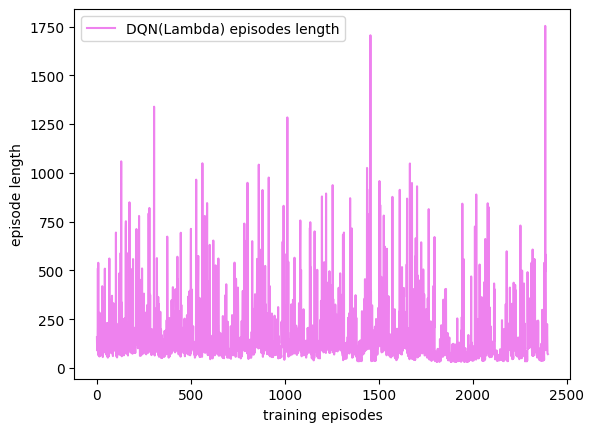

In [ ]:
plt.plot(DQNLambda_time_passed, color = 'violet')
plt.legend(["DQN(Lambda) episodes length"], loc ="upper left")
plt.ylabel('episode length')
plt.xlabel('training episodes')
plt.show()

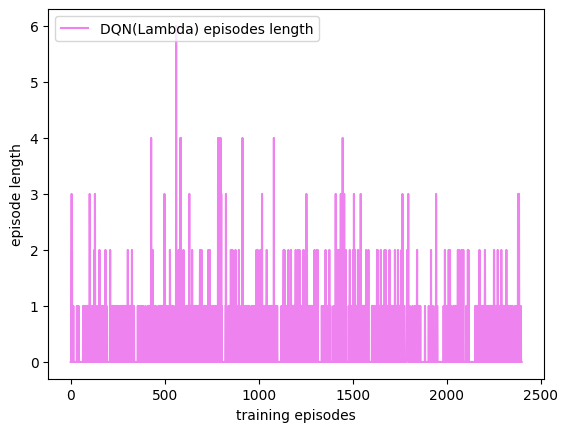

In [ ]:
plt.plot(DQNLambda_scores, color = 'violet')
plt.legend(["DQN(Lambda) episodes length"], loc ="upper left")
plt.ylabel('episode length')
plt.xlabel('training episodes')
plt.show()

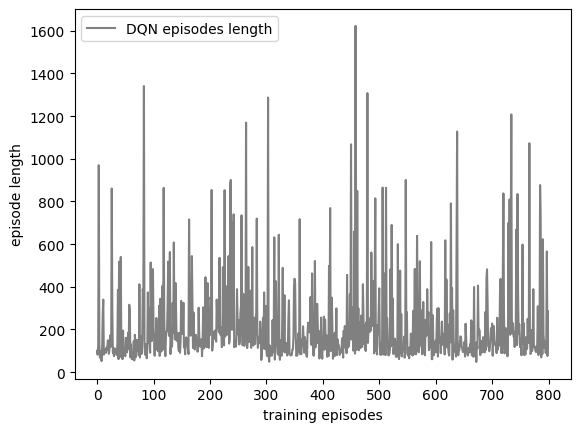

In [ ]:
plt.plot(DQN_time_passed, color = 'grey')
plt.legend(["DQN episodes length"], loc ="upper left")
plt.ylabel('episode length')
plt.xlabel('training episodes')
plt.show()

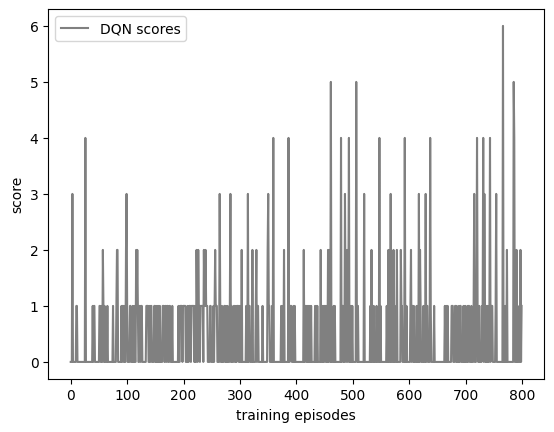

In [ ]:
plt.plot(DQN_scores, color = 'grey')
plt.legend(["DQN scores"], loc ="upper left")
plt.ylabel('score')
plt.xlabel('training episodes')
plt.show()